In [94]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy import stats, integrate, optimize, special
import random
from scipy import interpolate


In [112]:
# 関数の定義
def model_beta(x, alpha, beta):
    Np = 618
    f = lambda a: ( ((a ** (alpha - 1)) * ((1 - a)**(beta - 1))) / special.beta(alpha, beta)) * (1 - ((((alpha + beta)) * (2*a*x[0]) ) / (alpha*Np**2 - alpha*Np))) **(Np - 1)
    ff, _ = integrate.quad(f, 0, 1)  # 積分の値と推定誤差を別々に受け取る
    func = Np * (1 - ff) 
    return func

In [96]:
# /data/df.pickleの読み込み
df = pd.read_pickle('../data/df.pickle')

df = df.dropna()

# データの分割
df_p1 = df[(df['started_at'] >= '2020-03-01') & (df['started_at'] < '2020-06-01')].dropna()
df_p2 = df[(df['started_at'] >= '2020-06-01') & (df['started_at'] < '2020-11-01')].dropna()
df_p3 = df[(df['started_at'] >= '2020-12-01') & (df['started_at'] < '2021-03-01')].dropna()
df_p4 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2023-10-01')].dropna()
df_p4_1 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2022-01-01')].dropna()
df_p4_2 = df[(df['started_at'] >= '2022-01-01') & (df['started_at'] < '2023-10-01')].dropna()
df_left = pd.concat([df_p1, df_p2, df_p3, df_p4_1], axis=0)
df_right = pd.concat([df_p4_2], axis=0)

In [97]:
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_listとedge_listで0の値を削除
    node_list = np.array(node_list)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    active_node_list = node_list[node_list != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_list)]
    
    return active_node_list, edge_list, timestamp

In [98]:
# left
node_left, edge_left, timestamp_left = return_nm(df_left)

In [113]:
print("+------------------+")
print("| Estimating       |")
print("+------------------+")

params, _ = optimize.curve_fit(model_beta, xdata=edge_left, ydata=node_left)

print("alpha: ", params[0])
print("beta: ", params[1])

+------------------+
| Estimating       |
+------------------+
alpha:  0.6299967378826827
beta:  1.635334493207898


/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_10932/276521255.py:5: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  ff, _ = integrate.quad(f, 0, 1)  # 積分の値と推定誤差を別々に受け取る


In [114]:
Np = max(node_left)
alpha = params[0]
beta = params[1]

kappa = []
for i in range(len(edge_left)):
    kappa.append( (((alpha + beta)/alpha)**2) * ((2 * edge_left[i]) / (Np**2 - Np)) )

In [115]:
Nfit = []
for i in range(len(edge_left)):
    Nfit.append(model_beta([edge_left[i]], alpha, beta))

In [116]:
Mfit = []
for i in range(len(edge_left)):
    Mfit.append((kappa[i]*Np*(Np-1))/8)

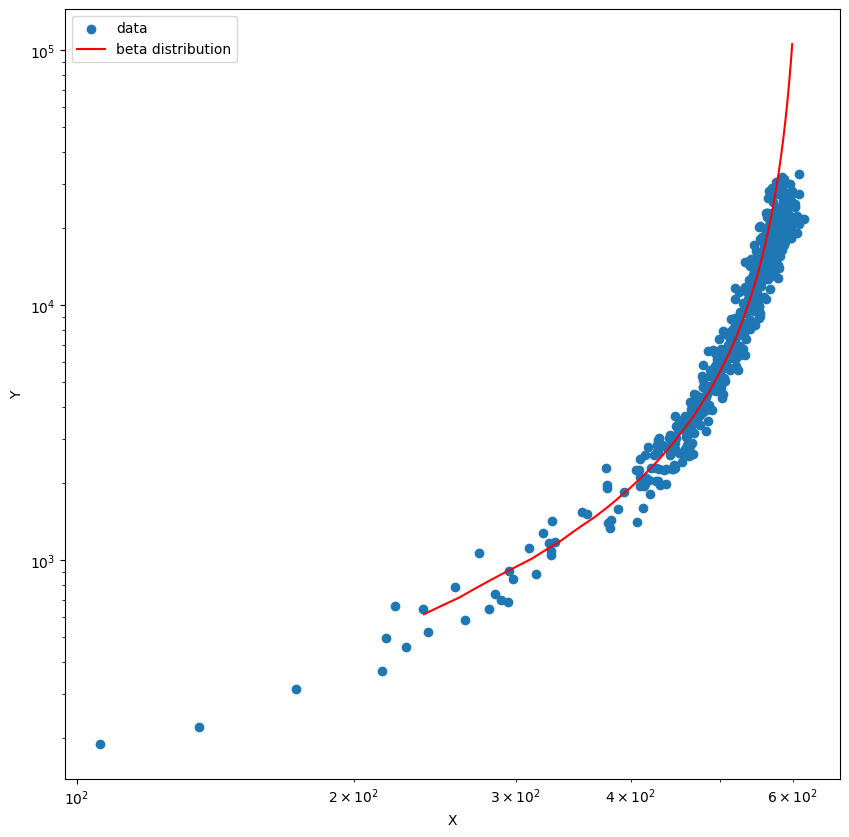

In [117]:
# 隣接する点を繋ぐように線形補間
spline_func = interpolate.interp1d(Nfit, Mfit,
                                   kind="linear")
x_new = np.linspace(min(Nfit), max(Nfit), 1000)
y_new = spline_func(x_new)

# 可視化
plt.figure(figsize=(10, 10))
plt.scatter(node_left, edge_left, label='data')
plt.plot(x_new, y_new, "-", c="red", label="beta distribution")
plt.xlabel('X')
plt.ylabel('Y')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [104]:
# 正規化する
node_norm = node_left - min(node_left) + 2
edge_norm = edge_left - min(edge_left) + 1

In [105]:
max(node_norm)

514

In [106]:
# 関数の定義
def model_beta_norm(x, alpha, beta):
    Np = 514
    f = lambda a: ( ((a ** (alpha - 1)) * ((1 - a)**(beta - 1))) / special.beta(alpha, beta)) * (1 - ((((alpha + beta)) * (2*a*x[0]) ) / (alpha*Np**2 - alpha*Np))) **(Np - 1)
    ff, _ = integrate.quad_vec(f, 0, 1)  # 積分の値と推定誤差を別々に受け取る
    func = Np * (1 - ff) 
    return func

In [107]:
print("+------------------+")
print("| Estimating       |")
print("+------------------+")

params, _ = optimize.curve_fit(model_beta_norm, xdata=edge_norm, ydata=node_norm)

print("alpha: ", params[0])
print("beta: ", params[1])

+------------------+
| Estimating       |
+------------------+
alpha:  0.5861354776598224
beta:  5.393372514911838


/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_10932/2271888008.py:4: RuntimeWarning: overflow encountered in scalar power
  f = lambda a: ( ((a ** (alpha - 1)) * ((1 - a)**(beta - 1))) / special.beta(alpha, beta)) * (1 - ((((alpha + beta)) * (2*a*x[0]) ) / (alpha*Np**2 - alpha*Np))) **(Np - 1)
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_10932/2271888008.py:4: RuntimeWarning: divide by zero encountered in scalar power
  f = lambda a: ( ((a ** (alpha - 1)) * ((1 - a)**(beta - 1))) / special.beta(alpha, beta)) * (1 - ((((alpha + beta)) * (2*a*x[0]) ) / (alpha*Np**2 - alpha*Np))) **(Np - 1)
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_10932/2271888008.py:4: RuntimeWarning: overflow encountered in scalar divide
  f = lambda a: ( ((a ** (alpha - 1)) * ((1 - a)**(beta - 1))) / special.beta(alpha, beta)) * (1 - ((((alpha + beta)) * (2*a*x[0]) ) / (alpha*Np**2 - alpha*Np))) **(Np - 1)


In [108]:
Np = max(node_norm)
alpha = params[0]
beta = params[1]

Nnorm_fit = []
for i in range(len(edge_norm)):
    Nnorm_fit.append(model_beta([edge_norm[i]], alpha, beta))

Mnorm_fit = []
for i in range(len(kappa)):
    Mnorm_fit.append(((kappa[i] * (Np ** 2)) - (kappa[i] * Np)) / 8)

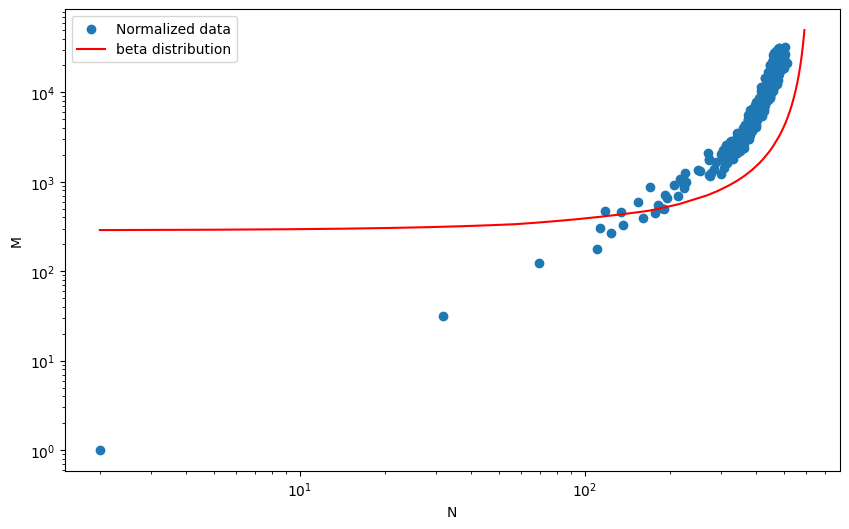

In [109]:
# 隣接する点を繋ぐように線形補間
spline_func = interpolate.interp1d(Nnorm_fit, Mnorm_fit,
                                   kind="linear")
x_new = np.linspace(min(Nnorm_fit), max(Nnorm_fit), 1000)
y_new = spline_func(x_new)

plt.figure(figsize=(10, 6))
# plt.scatter(node_left, edge_left, label="left")
# plt.scatter(Nnorm_fit, Mnorm_fit, label="fit", c="red") 
plt.scatter(node_norm, edge_norm, label="Normalized data")
plt.plot(x_new, y_new, "-", c="red", label="beta distribution")
# node_normとMnorm_fitの間を補間する

plt.xlabel("N")
plt.ylabel("M")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()


In [111]:
min(edge_norm )

1

## ベータ分布

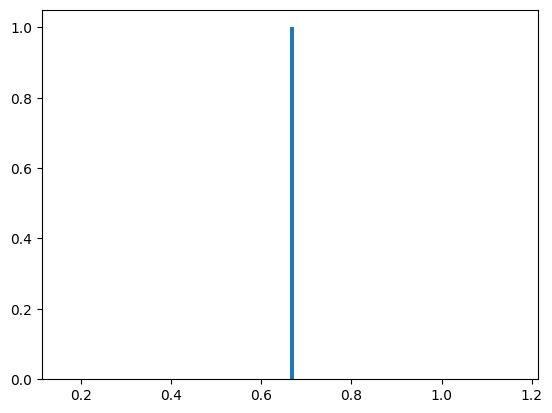

In [189]:
# rvs from beta distribution
alpha = 1.0
beta = 0.5
rvs = stats.beta.rvs(alpha, beta, size=1)
plt.hist(rvs, bins=100)
plt.show()
